In [1]:
import os
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

import pandas as pd
import numpy as np

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# <br><br> Built-in function

In [2]:
from typing import List, Union
from scipy.stats import rankdata

def cumulative_percentile(
    series: pd.Series,
    rolling_window: Union[int, float] = 1e10,
    show_progress: bool = True
) -> pd.Series:
    """
    Computes the cumulative percentile of each value in a time series,
    optionally within a rolling window.

    Parameters
    ----------
    series : pd.Series
        The input time series.
    rolling_window : int or float, optional
        Number of past values to consider (including current). If large (default=1e10),
        computes percentiles over the entire history up to each point.
    show_progress : bool, optional
        Whether to show a tqdm progress bar.

    Returns
    -------
    pd.Series
        A series of percentiles (0–100) for each value, aligned with the original index.
    """
    percentiles = []
    iterator = tqdm(range(len(series))) if show_progress else range(len(series))

    for i in iterator:
        # Define the rolling window range
        start = max(0, int(i - rolling_window))
        current_values = series[start:i + 1].dropna()

        # Handle edge cases
        if len(current_values) == 0 or np.isnan(series.values[i]):
            percentiles.append(np.nan)
            continue

        # Rank the current values
        ranks = rankdata(current_values)
        percentile = (ranks[-1] - 1) / (len(current_values) - 1) * 100
        percentiles.append(percentile)

    return pd.Series(percentiles, index=series.index)

# <br><br> 1. Download data and preprocess

1. **Connect to Postgres**  
   Loads credentials from `.env` and creates a SQLAlchemy engine.

2. **Sanity check tables**  
   Prints schema (columns & types) and row counts for  
   `market_metrics`, `daily_summaries`, and `individual_trades`.

3. **Load dataframes**  
   Reads the three tables into pandas DataFrames.

4. **Normalize dates**  
   Converts time fields to `datetime` and creates a common `date` column.

5. **Reshape metrics (long → wide)**  
   Pivots `market_metrics` so each `metric_name` becomes its own column, aligned by `date`.

6. **Plot all metrics**  
   Uses Plotly to visualize each metric over time.

7. **Clean & refine**  
   Removes unwanted metrics, fixes outliers in `GEX_aggregate_bn` (replaced with `NaN` + interpolated), and replots.

8. **Shortlist for review**  
   Defines `for_review` with selected metrics for deeper inspection.

In [3]:
load_dotenv()
HOST = os.getenv("PG_HOST")
DB   = os.getenv("PG_DB")
USER = os.getenv("PG_USER")
PWD  = os.getenv("PG_PASSWORD")

engine = create_engine(f"postgresql+psycopg2://{USER}:{PWD}@{HOST}/{DB}")

# 1) sanity: peek schema & counts
datasets = [
    'market_metrics',
    'daily_summaries',
    'individual_trades'
]
for t in datasets:
    cols = pd.read_sql(f"""
        SELECT column_name, data_type
        FROM information_schema.columns
        WHERE table_name = '{t}'
        ORDER BY ordinal_position
    """, engine)
    
    cnt  = pd.read_sql(f"SELECT COUNT(*) AS n FROM {t};", engine)
    
    print(f"\n=== {t} ===\n", cols, "\nrows:", int(cnt['n'][0]))


=== market_metrics ===
     column_name                 data_type
0     timestamp  timestamp with time zone
1   metric_name         character varying
2  metric_value                   numeric
3     data_type         character varying
4        source         character varying
5    created_at  timestamp with time zone 
rows: 97527

=== daily_summaries ===
    column_name          data_type
0         date               date
1       trades            integer
2         wins            integer
3      avg_win            numeric
4      win_pct            numeric
5       losses            integer
6     avg_loss            numeric
7     loss_pct            numeric
8    total_pnl            numeric
9   trade_date               date
10        type  character varying 
rows: 3381

=== individual_trades ===
      column_name                    data_type
0        type_in            character varying
1    datetime_in     timestamp with time zone
2       price_in                      numeric
3      con

In [4]:
# 2) pull full tables (2020-01-01 onward)

# market_metrics - All pre-market indicators (40+ metrics collected at 8:30 AM)
# daily_summaries - Daily trade outcomes (P&L, trade count, win rate)
# individual_trades - Detailed trade-by-trade data

with engine.connect() as conn:
    market_metrics = pd.read_sql(text("SELECT * FROM market_metrics;"), conn)
    daily_summaries = pd.read_sql(text("SELECT * FROM daily_summaries;"), conn)
    individual_trades = pd.read_sql(text("SELECT * FROM individual_trades;"), conn)

# Convert to datetime column
market_metrics["timestamp"] = pd.to_datetime(market_metrics["timestamp"])
daily_summaries["date"] = pd.to_datetime(daily_summaries["date"])
daily_summaries["trade_date"] = pd.to_datetime(daily_summaries["trade_date"])
individual_trades["datetime_in"] = pd.to_datetime(individual_trades["datetime_in"])
individual_trades["datetime_out"] = pd.to_datetime(individual_trades["datetime_out"])
individual_trades["trade_date"] = pd.to_datetime(individual_trades["trade_date"])

# Common date column to merge later...
market_metrics['date'] = market_metrics['timestamp'].dt.date
daily_summaries['date'] = daily_summaries['date'].dt.date
individual_trades['date'] = individual_trades['trade_date'].dt.date

# --- Filter to YM data ---
STRAETGY = 'ng'
daily_summaries = daily_summaries[daily_summaries['type'] == STRAETGY]
individual_trades = individual_trades[individual_trades['type'] == STRAETGY]
# market_metrics = market_metrics[market_metrics['metric_name'].apply(lambda x: STRAETGY.upper() in x)]

daily_summaries

date  trades  wins  avg_win  win_pct  losses  avg_loss  loss_pct  \
2190  2021-01-04       1     1   505.48     1.00       0      0.00      0.00   
2191  2021-01-05       3     1   135.48     0.33       2   -154.52      0.67   
2192  2021-01-06       1     1   795.48     1.00       0      0.00      0.00   
2193  2021-01-07       3     1   295.48     0.33       2   -304.52      0.67   
2194  2021-01-08       3     1   365.48     0.33       2   -154.52      0.67   
...          ...     ...   ...      ...      ...     ...       ...       ...   
3291  2025-09-10       2     1    35.48     0.50       1   -154.52      0.50   
3292  2025-09-11       1     1   495.48     1.00       0      0.00      0.00   
3293  2025-09-12       1     0     0.00     0.00       1    -54.52      1.00   
3294  2025-09-15       1     1   795.48     1.00       0      0.00      0.00   
3295  2025-09-16       5     1   325.48     0.20       4   -154.52      0.80   

      total_pnl trade_date type  
2190     505.48 2021-01-04   ng  
2191    -173.56 2021-01-05   ng  
2192     795.48 2021-01-06   ng  
2193    -313.56 2021-01-07   ng  
2194      56.44 2021-01-08   ng  
...         ...        ...  ...  
3291    -119.04 2025-09-10   ng  
3292     495.48 2025-09-11   ng  
3293     -54.52 2025-09-12   ng  
3294     795.48 2025-09-15   ng  
3295    -292.60 2025-09-16   ng  

[1106 rows x 11 columns]

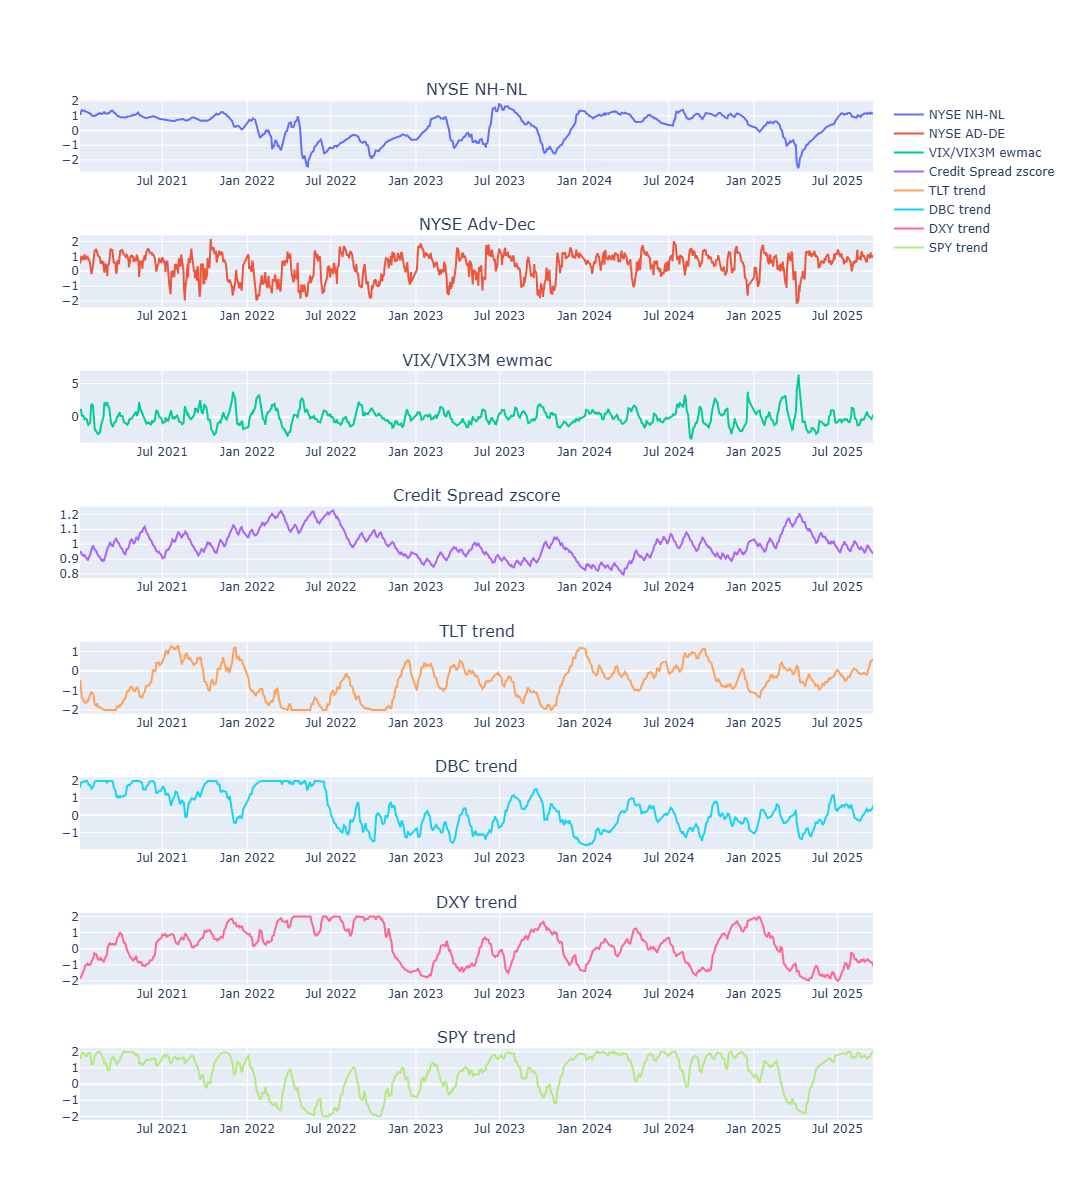

In [21]:
# --- Market metrics from FRD, TradingView, for market regime detection ---
# VIX
# VIX3M
# QQQ
# Credit Spread
# TLT
# QQQ breadth
# DXY
# DBC

from tvDatafeed import TvDatafeed, Interval
from fredapi import Fred

tv = TvDatafeed()
fred = Fred(api_key="TU_API_KEY_AQUI")

# -------------------------------------------------------------------
# Advance/Decline, NewHighs-NewLows data from NYSE
# -------------------------------------------------------------------
# 1-year  NYSE New Highs
mahn = tv.get_hist(symbol='MAHN', exchange='INDEX', interval=Interval.in_daily,n_bars=6000)

# 1-year  NYSE New lOWS
maln = tv.get_hist(symbol='MALN', exchange='INDEX', interval=Interval.in_daily,n_bars=6000)

# NYSE advance issues
advn = tv.get_hist(symbol='ADVN.NY', exchange='USI', interval=Interval.in_daily,n_bars=6000)

# NYSE decline issues
decl = tv.get_hist(symbol='DECL.NY', exchange='USI', interval=Interval.in_daily,n_bars=6000)

# --- Convert dataframe to appropiate format ---
def convert_tv_df(df, name):
    df['date'] = df.index
    df['date'] = pd.to_datetime(df['date'])
    df['date'] = df['date'].dt.date
    df[name] = df['close']
    df.index = range(len(df))
    df = df[['date', name]]

    return df

mahn, maln, advn, decl = convert_tv_df(mahn, 'mahn'), convert_tv_df(maln, 'maln'), convert_tv_df(advn, 'advn'), convert_tv_df(decl, 'decl')

data = pd.merge(mahn, maln, on='date', how='inner')
data = pd.merge(data, advn, on='date', how='inner')
data = pd.merge(data, decl, on='date', how='inner')

data['nh_nl'] = (data['mahn'] - data['maln']).cumsum()
data['ad_de'] = (data['advn'] - data['decl']).cumsum()

data['nh_nl_zscore'] = (data['nh_nl'] - data['nh_nl'].ewm(span=40).mean()) / data['nh_nl'].ewm(span=40).std()
data['ad_de_zscore'] = (data['ad_de'] - data['ad_de'].ewm(span=21).mean()) / data['ad_de'].ewm(span=21).std()

# -------------------------------------------------------------------
# SPY Implied Vol
# -------------------------------------------------------------------
vix = tv.get_hist(symbol='VIX', exchange='CBOE', interval=Interval.in_daily,n_bars=6000)
vix3m = tv.get_hist(symbol='VIX3M', exchange='CBOE', interval=Interval.in_daily,n_bars=6000)

vix, vix3m = convert_tv_df(vix, 'vix'), convert_tv_df(vix3m, 'vix3m')

data = pd.merge(data, vix, on='date', how='inner')
data = pd.merge(data, vix3m, on='date', how='inner')

data['vix_vix3m'] = data['vix'] / data['vix3m']
data['vix_vix3m_ewmac'] = data['vix_vix3m'].ewm(span=7).mean() - data['vix_vix3m'].ewm(span=12).mean()
data['vix_vix3m_ewmac'] /= data['vix_vix3m_ewmac'].abs().expanding().mean()

# -------------------------------------------------------------------
# Credit Spread
# -------------------------------------------------------------------
from fredapi import Fred
fred = Fred(api_key="602df0dfcd95910a9b540ee2781049f8")

series_id = "BAMLH0A0HYM2"
credit_spread = fred.get_series(series_id)
credit_spread = pd.DataFrame({
    'date': credit_spread.index,
    'cs': credit_spread
})
credit_spread['date'] = credit_spread['date'].dt.date
credit_spread.index = range(len(credit_spread))

credit_spread['cs'] = (credit_spread['cs'] > credit_spread['cs'].shift(5)).astype(float).cumsum()
credit_spread['cs_zscore'] = (credit_spread['cs'] - credit_spread['cs'].ewm(span=252).mean()) / credit_spread['cs'].ewm(span=252).std()
credit_spread = credit_spread[['date', 'cs_zscore']]

data = pd.merge(data, credit_spread, on='date', how='inner')

# -------------------------------------------------------------------
# Bonds, Commodities, Dollar, and Equity: data from Investing.com
# -------------------------------------------------------------------
tlt = pd.read_csv('data/TLT.csv').iloc[::-1]
tlt['date'] = pd.to_datetime(tlt['Fecha'])
tlt['date'] = tlt['date'].dt.date
tlt['tlt'] = tlt['Último'].apply(lambda x: x.replace(',', '.')).astype(float)
tlt = tlt[['date', 'tlt']]

dbc = pd.read_csv('data/DBC.csv').iloc[::-1]
dbc['date'] = pd.to_datetime(dbc['Date'])
dbc['date'] = dbc['date'].dt.date
dbc['dbc'] = dbc['Price'].astype(float)
dbc = dbc[['date', 'dbc']]

dxy = pd.read_csv('data/DXY.csv').iloc[::-1]
dxy['date'] = pd.to_datetime(dxy['Date'])
dxy['date'] = dxy['date'].dt.date
dxy['dxy'] = dxy['Price'].astype(float)
dxy = dxy[['date', 'dxy']]

spy = pd.read_csv('data/SPY.csv').iloc[::-1]
spy['date'] = pd.to_datetime(spy['Date'])
spy['date'] = spy['date'].dt.date
spy['spy'] = spy['Price'].astype(float)
spy = spy[['date', 'spy']]

def trend_signal(df, close):
    """
    This function calculates Trend signal doing an average of EWMAC with different time windws
    """
    spans = [
        5,
        10,
        20,
        40
    ]
    for span in spans:
        df[f'{close}_{span}'] = df[close].ewm(span=span).mean() - df[close].ewm(span=4*span).mean()
        df[f'{close}_{span}'] /= df[f'{close}_{span}'].abs().expanding().mean()
        df[f'{close}_{span}'] = df[f'{close}_{span}'].clip(-2,2)

    df[f'{close}_trend'] = df[[f'{close}_{span}' for span in spans]].mean(axis=1)
    return df[f'{close}_trend']

tlt['tlt_trend'] = trend_signal(tlt, 'tlt')
dbc['dbc_trend'] = trend_signal(dbc, 'dbc')
dxy['dxy_trend'] = trend_signal(dxy, 'dxy')
spy['spy_trend'] = trend_signal(spy, 'spy')

data = pd.merge(data, tlt, on='date', how='inner')
data = pd.merge(data, dbc, on='date', how='inner')
data = pd.merge(data, dxy, on='date', how='inner')
data = pd.merge(data, spy, on='date', how='inner')

# -------------------------------------------------------------------
# Final dataset...
# -------------------------------------------------------------------
data = data[[
    'date',
    'nh_nl_zscore',
    'ad_de_zscore',
    'vix_vix3m_ewmac',
    'vix',
    'cs_zscore',
    'tlt_trend',
    'dbc_trend',
    'dxy_trend',
    'spy_trend'
]]

# --- Merge with daily summaries ---
data = pd.merge(data, daily_summaries, on='date', how='inner')

subplot_titles = [
    'NYSE NH-NL',
    'NYSE Adv-Dec',
    'VIX/VIX3M ewmac',
    'Credit Spread zscore',
    'TLT trend',
    'DBC trend',
    'DXY trend',
    'SPY trend'
]

fig = make_subplots(rows=8, cols=1, subplot_titles=subplot_titles)

fig.add_trace(go.Scatter(x=data.date, y=data.nh_nl_zscore, name='NYSE NH-NL'), row=1, col=1)
fig.add_trace(go.Scatter(x=data.date, y=data.ad_de_zscore, name='NYSE AD-DE'), row=2, col=1)
fig.add_trace(go.Scatter(x=data.date, y=data.vix_vix3m_ewmac, name='VIX/VIX3M ewmac'), row=3, col=1)
fig.add_trace(go.Scatter(x=data.date, y=data.cs_zscore, name='Credit Spread zscore'), row=4, col=1)
fig.add_trace(go.Scatter(x=data.date, y=data.tlt_trend, name='TLT trend'), row=5, col=1)
fig.add_trace(go.Scatter(x=data.date, y=data.dbc_trend, name='DBC trend'), row=6, col=1)
fig.add_trace(go.Scatter(x=data.date, y=data.dxy_trend, name='DXY trend'), row=7, col=1)
fig.add_trace(go.Scatter(x=data.date, y=data.spy_trend, name='SPY trend'), row=8, col=1)

fig.update_layout(width=1000, height=1200)

# <br><br> 2. EDA

This section analyzes how key market features relate to short-term strategy performance.  
We use eight features reflecting market breadth, volatility, credit conditions, and macro trends:

`nh_nl_zscore`, `ad_de_zscore`, `vix_vix3m_ewmac`, `cs_zscore`, `tlt_trend`, `dbc_trend`, `dxy_trend`, `spy_trend`.

---

### 1. Rolling Forward Metrics

We compute:
- **% of profitable days** (1-month forward rolling window).  
- **Forward buy/sell profits**, aggregated over the same window.

Each plot shows the feature (top) and profitability dynamics (bottom), revealing how market conditions affect upcoming returns.

---

### 2. Regression: Buys vs Sells Forward Profits

We fit a linear regression between **buy** and **sell** forward profits to measure dependency.  
The slope (β) and R² show whether long and short performance move together or alternate across regimes.

---

### 3. Regression: Profitability vs Forward Profits

We regress the **% of profitable days** against forward **buy** and **sell** profits to test how trade success aligns with directional performance.  
Each scatter includes the regression line with β, α, and R² for interpretability.

---

**Goal:**  
Link feature behavior to future profitability, assessing how well the market signals anticipate favorable or unfavorable trading conditions.


In [83]:
features = [
    'nh_nl_zscore',
    'ad_de_zscore',
    'vix_vix3m_ewmac',
    'cs_zscore',
    'tlt_trend',
    'dbc_trend',
    'dxy_trend',
    'spy_trend'
]

# --- % of days in profit, rolling 1-month (forward looking) ---
window = 21
data['positive_days'] = ((data['total_pnl'] > 0).astype(int).rolling(window).sum() / window).shift(-window)

# --- Buys/Sells accumulated profit, rolling 1-month (forward looking) ---
buys_profits, sells_profits = [], []
for _, row in data.iterrows():
    trades_filt = individual_trades[individual_trades['date'] == row['date']]
    buys, sells = trades_filt[trades_filt['type_in'] == 'Long'], trades_filt[trades_filt['type_in'] == 'Short']

    # buys_profit = (buys['price_out'] / buys['price_in'] - 1).sum()
    # sells_profit = (sells['price_in'] / sells['price_out'] - 1).sum()
    buys_profit = buys['profit_loss'].sum()
    sells_profit = sells['profit_loss'].sum()

    buys_profits.append(buys_profit)
    sells_profits.append(sells_profit)

data['buys_profit'] = buys_profits
data['sells_profit'] = sells_profits

data['buys_forward_profit'] = data['buys_profit'].rolling(window).sum().shift(-window-1)
data['sells_forward_profit'] = data['sells_profit'].rolling(window).sum().shift(-window-1)

# --- Plot, output vs features ---
for feature in features:
    fig = make_subplots(rows=2, cols=1, specs=[[{}], [{'secondary_y':True}]])
    
    fig.add_trace(go.Scatter(x=data.date, y=data[feature], name=feature))
    
    fig.add_trace(go.Scatter(x=data.date, y=data.positive_days, name='% days in profit'), row=2, col=1)
    fig.add_trace(go.Scatter(x=data.date, y=data.buys_forward_profit, name='BUYs profit'), row=2, col=1, secondary_y=True)
    fig.add_trace(go.Scatter(x=data.date, y=data.sells_forward_profit, name='SELLs profit'), row=2, col=1, secondary_y=True)

    fig.update_layout(width=1000, height=600)
    fig.show()

In [84]:
# Lets plot % of days in profit vs buys/sells total profit, both 1-month forward
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# 1) Prepare and clean
df = pd.DataFrame({
    "x": pd.to_numeric(data["buys_forward_profit"], errors="coerce"),
    "y": pd.to_numeric(data["sells_forward_profit"], errors="coerce"),
}).replace([np.inf, -np.inf], np.nan).dropna()

if df.empty or df["x"].nunique() < 2:
    raise ValueError("No hay suficientes datos válidos (o x no varía) para ajustar la regresión.")

X = df["x"].to_numpy(dtype=float).reshape(-1, 1)
y = df["y"].to_numpy(dtype=float)

# 2) Sklearn fit
model = LinearRegression().fit(X, y)
beta = float(model.coef_[0])
alpha = float(model.intercept_)
y_pred = model.predict(X)
r2 = float(r2_score(y, y_pred))

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df["x"], y=df["y"], mode='markers', name='Data'
))

# Regression line
x_line = np.linspace(df["x"].min(), df["x"].max(), 200)
y_line = beta * x_line + alpha
fig.add_trace(go.Scatter(
    x=x_line, y=y_line, mode='lines',
    name=f'Regression (beta={beta:.3f}, R²={r2:.3f})'
))

# Annotate beta and R2
fig.update_layout(
    width=1000, height=700,
    title="Scatter with regression",
    annotations=[dict(
        x=0.02, y=0.98, xref="paper", yref="paper", showarrow=False,
        text=f"β={beta:.4f}  α={alpha:.4f}  R²={r2:.4f}",
        font=dict(size=12)
    )]
)

fig.show()

In [85]:
# Lets plot % of days in profit vs buys/sells total profit, both 1-month forward
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# 1) Prepare and clean
df = pd.DataFrame({
    "x": pd.to_numeric(data["buys_forward_profit"], errors="coerce"),
    "y": pd.to_numeric(data["positive_days"], errors="coerce"),
}).replace([np.inf, -np.inf], np.nan).dropna()

X = df["x"].to_numpy(dtype=float).reshape(-1, 1)
y = df["y"].to_numpy(dtype=float)

# 2) Sklearn fit
model = LinearRegression().fit(X, y)
beta = float(model.coef_[0])
alpha = float(model.intercept_)
y_pred = model.predict(X)
r2 = float(r2_score(y, y_pred))

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df["x"], y=df["y"], mode='markers', name='Data'
))

# Regression line
x_line = np.linspace(df["x"].min(), df["x"].max(), 200)
y_line = beta * x_line + alpha
fig.add_trace(go.Scatter(
    x=x_line, y=y_line, mode='lines',
    name=f'Regression (beta={beta:.3f}, R²={r2:.3f})'
))

# Annotate beta and R2
fig.update_layout(
    width=1000, height=700,
    title="Scatter with regression",
    annotations=[dict(
        x=0.02, y=0.98, xref="paper", yref="paper", showarrow=False,
        text=f"β={beta:.4f}  α={alpha:.4f}  R²={r2:.4f}",
        font=dict(size=12)
    )]
)

fig.show()


In [86]:
# Lets plot % of days in profit vs buys/sells total profit, both 1-month forward
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# 1) Prepare and clean
df = pd.DataFrame({
    "x": pd.to_numeric(data["sells_forward_profit"], errors="coerce"),
    "y": pd.to_numeric(data["positive_days"], errors="coerce"),
}).replace([np.inf, -np.inf], np.nan).dropna()

X = df["x"].to_numpy(dtype=float).reshape(-1, 1)
y = df["y"].to_numpy(dtype=float)

# 2) Sklearn fit
model = LinearRegression().fit(X, y)
beta = float(model.coef_[0])
alpha = float(model.intercept_)
y_pred = model.predict(X)
r2 = float(r2_score(y, y_pred))

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df["x"], y=df["y"], mode='markers', name='Data'
))

# Regression line
x_line = np.linspace(df["x"].min(), df["x"].max(), 200)
y_line = beta * x_line + alpha
fig.add_trace(go.Scatter(
    x=x_line, y=y_line, mode='lines',
    name=f'Regression (beta={beta:.3f}, R²={r2:.3f})'
))

# Annotate beta and R2
fig.update_layout(
    width=1000, height=700,
    title="Scatter with regression",
    annotations=[dict(
        x=0.02, y=0.98, xref="paper", yref="paper", showarrow=False,
        text=f"β={beta:.4f}  α={alpha:.4f}  R²={r2:.4f}",
        font=dict(size=12)
    )]
)

fig.show()


# <br><br> 3. Feature predictive power

This section studies how each market feature relates to the **future performance** of long and short trades.  
Each feature is divided into **five quintiles** (1 = weakest, 5 = strongest) using cumulative percentiles, allowing comparison of strategy profitability across different market states.

---

### 1. Spearman Correlation and Buy-Side Analysis

We compute the **Spearman correlation** between each feature and the buys profit (`buys_profit`).  
Then, we visualize the **average forward buy profit per feature quintile**, sorted by correlation strength.

This helps identify which signals tend to precede stronger long performance — e.g., features that align with risk-on phases should show higher buy profits in upper quintiles.

---

### 2. Spearman Correlation and Sell-Side Analysis

The same process is applied using the sells profit (`sells_profit`).  
Average sell profits are plotted by feature quintile, highlighting features that anticipate favorable short-selling environments (risk-off conditions).

---

**Goal:**  
Evaluate how the strategy’s future profitability depends on the level of each feature, confirming which indicators consistently align with risk-on or risk-off market regimes.


In [87]:
features = [
    'nh_nl_zscore',
    'ad_de_zscore',
    'vix_vix3m_ewmac',
    'cs_zscore',
    'tlt_trend',
    'dbc_trend',
    'dxy_trend',
    'spy_trend'
]

for feature in tqdm(features):
    data[f'{feature}_q'] = (cumulative_percentile(data[feature], 1e10, False) // 20 + 1).clip(1,5)

features_corr = []
for feature in features:
    corr = data[feature].corr(data["buys_profit"], method="spearman")
    features_corr.append(corr)

df = pd.DataFrame({
    'feature': features,
    'corr': features_corr,
    'corr_abs': np.abs(features_corr),
})
df.sort_values('corr_abs', ascending=False, inplace=True)

features_sorted = df['feature'].values

# --- Plot average BUYs profit vs feature quintile ---
subplot_titles = [f'{feature}: {round(corr, 2)}' for feature, corr in zip(df['feature'].values, df['corr'].values)]
fig = make_subplots(rows=3, cols=3, subplot_titles=subplot_titles)

for cont, feature in enumerate(features_sorted):
    col_id = cont % 3 + 1
    row_id = cont // 3 + 1
    
    results = {
        'quintile': [],
        'mean': [],
        'median': [],
    }
    for quintile in range(1,6):
        data_filt = data[data[f'{feature}_q'] == quintile]
    
        mean_ = data_filt['buys_profit'].mean()
        median_ = data_filt['buys_profit'].median()
    
        results['quintile'].append(quintile)
        results['mean'].append(mean_)
        results['median'].append(median_)
    
    fig.add_trace(go.Bar(x=results['quintile'], y=results['mean'], showlegend=False, marker_color="steelblue"), row=row_id, col=col_id)

fig.update_layout(
    width=1000,
    height=800,
    title='Feature quintile vs BUYs average profit (sorted by spearman corr)',
    annotations=[
        dict(
            text=ann.text,
            x=ann.x,
            y=ann.y,
            xref=ann.xref,
            yref=ann.yref,
            showarrow=False,
            font=dict(size=12)   # <-- adjust this value
        )
        for ann in fig.layout.annotations
    ]
)
fig.show()

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.07it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.26it/s]


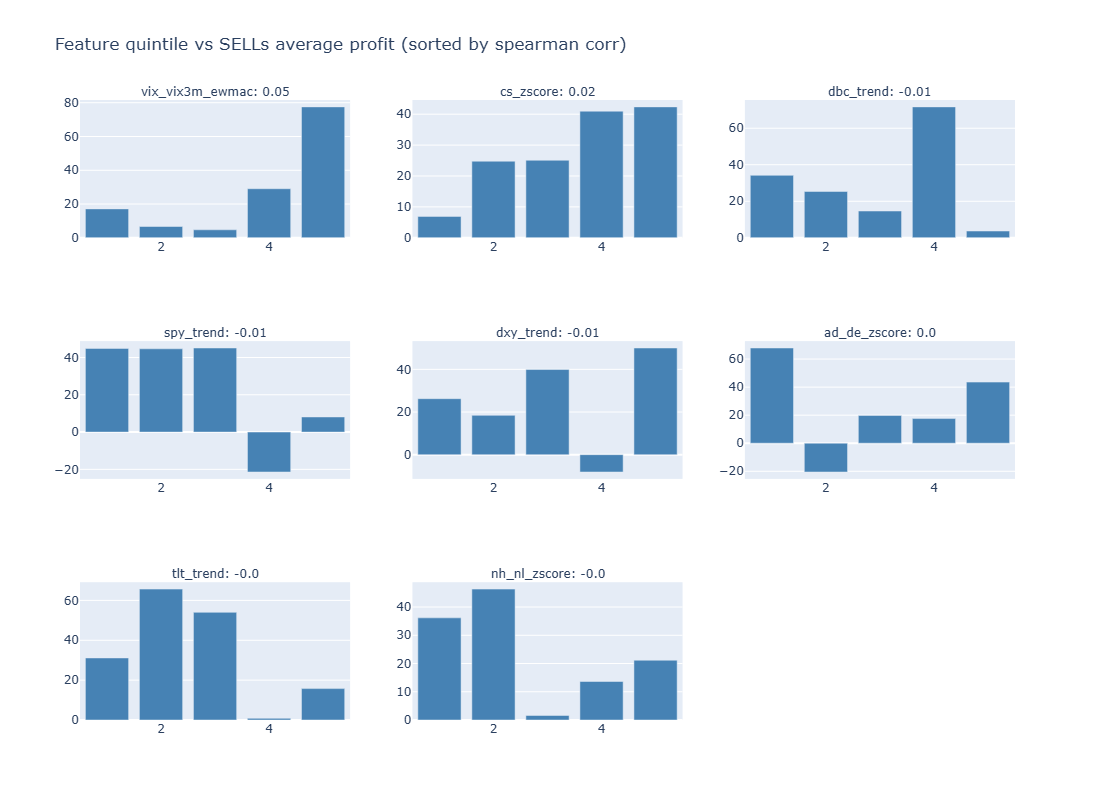

In [88]:
features = [
    'nh_nl_zscore',
    'ad_de_zscore',
    'vix_vix3m_ewmac',
    'cs_zscore',
    'tlt_trend',
    'dbc_trend',
    'dxy_trend',
    'spy_trend'
]

for feature in tqdm(features):
    data[f'{feature}_q'] = (cumulative_percentile(data[feature], 1e10, False) // 20 + 1).clip(1,5)

features_corr = []
for feature in features:
    corr = data[feature].corr(data["sells_profit"], method="spearman")
    features_corr.append(corr)

df = pd.DataFrame({
    'feature': features,
    'corr': features_corr,
    'corr_abs': np.abs(features_corr),
})
df.sort_values('corr_abs', ascending=False, inplace=True)

features_sorted = df['feature'].values

# --- Plot average BUYs profit vs feature quintile ---
subplot_titles = [f'{feature}: {round(corr, 2)}' for feature, corr in zip(df['feature'].values, df['corr'].values)]
fig = make_subplots(rows=3, cols=3, subplot_titles=subplot_titles)

for cont, feature in enumerate(features_sorted):
    col_id = cont % 3 + 1
    row_id = cont // 3 + 1
    
    results = {
        'quintile': [],
        'mean': [],
        'median': [],
    }
    for quintile in range(1,6):
        data_filt = data[data[f'{feature}_q'] == quintile]
    
        mean_ = data_filt['sells_profit'].mean()
        median_ = data_filt['sells_profit'].median()
    
        results['quintile'].append(quintile)
        results['mean'].append(mean_)
        results['median'].append(median_)
    
    fig.add_trace(go.Bar(x=results['quintile'], y=results['mean'], showlegend=False, marker_color="steelblue"), row=row_id, col=col_id)

fig.update_layout(
    width=1000,
    height=800,
    title='Feature quintile vs SELLs average profit (sorted by spearman corr)',
    annotations=[
        dict(
            text=ann.text,
            x=ann.x,
            y=ann.y,
            xref=ann.xref,
            yref=ann.yref,
            showarrow=False,
            font=dict(size=12)   # <-- adjust this value
        )
        for ann in fig.layout.annotations
    ]
)
fig.show()

# <br><br> 4. Blend signal

**Regime definition.**  
The composite **market_regime (1–5)** is built as  
`ad_de_zscore_q + tlt_trend_q − cs_zscore_q − vix_vix3m_ewmac_q`,  
then converted into quintiles (1 = risk-off, 5 = risk-on).

**Equity curves.**  
We track:
- `buys_equity` and `sells_equity`: cumulative profits by side.  
- `equity`: total strategy P&L.  
- `equity_filtered`: version that skips  
  - **Buys** in Regime 1 (risk-off).  
  - **Sells** in Regime 5 (risk-on).

**Metrics.**  
For both versions we compute **annualized return, volatility, max drawdown, Sharpe**, and **Calmar** ratios to measure performance impact.

**Skip accuracy.**  
We evaluate the model’s decisions:
- `good_skip_buys` / `bad_skip_buys` in Regime 1.  
- `good_skip_sells` / `bad_skip_sells` in Regime 5.  
Accuracy is the % of correctly skipped losing trades per side.

**Goal.**  
Compare the base ORB strategy with its regime-filtered version to assess improvements in returns, drawdown, and skip quality.


In [89]:
data['market_regime'] = data['ad_de_zscore_q'] + data['tlt_trend_q'] - data['vix_vix3m_ewmac_q'] - data['cs_zscore_q']
data['market_regime'] = (cumulative_percentile(data['market_regime'], 1e10, False) // 20 + 1).clip(1,5)

data['buys_equity'] = data['buys_profit'].cumsum()
data['sells_equity'] = data['sells_profit'].cumsum()
data['equity'] = data['total_pnl'].cumsum()

mask_1 = data['market_regime'] == 1
mask_2 = data['market_regime'] == 5
data['profit'] = data['buys_profit'] + data['sells_profit']
data.loc[mask_1, 'profit'] -= data.loc[mask_1, 'buys_profit']
data.loc[mask_2, 'profit'] -= data.loc[mask_2, 'sells_profit']
data['equity_filtered'] = data['profit'].cumsum()

fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Scatter(x=data.date, y=data.buys_equity, name='BUYs equity'))
fig.add_trace(go.Scatter(x=data.date, y=data.sells_equity, name='SELLs equity'))
fig.add_trace(go.Scatter(x=data.date, y=data.equity, name='ORB equity'))
fig.add_trace(go.Scatter(x=data.date, y=data.equity_filtered, name='ORB equity, Mkt Reg filt'))

fig.add_trace(go.Scatter(x=data.date, y=data.market_regime, name='Mkt Reg signal'), row=2, col=1)

fig.update_layout(width=1000, height=600)

In [90]:
# --- Repeat for test data ---
n_years = (data.date.max() - data.date.min()).days / 365
annualized_return = (data['equity'].values[-1] - data['equity'].values[0]) / n_years
annualized_vol = data['equity'].diff().std() * np.sqrt(252)
maxdd = (data['equity'].cummax() - data['equity']).max()
sharpe = annualized_return / annualized_vol
calmar = annualized_return / maxdd

annualized_return_filt = (data['equity_filtered'].values[-1] - data['equity_filtered'].values[0]) / n_years
annualized_vol_filt = data['equity_filtered'].diff().std() * np.sqrt(252)
maxdd_filt = (data['equity_filtered'].cummax() - data['equity_filtered']).max()
sharpe_filt = annualized_return_filt / annualized_vol_filt
calmar_filt = annualized_return_filt / maxdd_filt

print('ORB equity')
print('-----------------------------------')
print(f'Annualized return:     {int(annualized_return/1000)} k$')
print(f'Annualized vol:        {int(annualized_vol/1000)} k$')
print(f'Maximum drawdown:      {int(maxdd/1000)} k$')
print(f'Sharpe ratio:          {round(sharpe, 2)}')
print(f'Calmar ratio:          {round(calmar, 2)}')

print('\nORB + Mkt Reg equity')
print('-----------------------------------')
print(f'Annualized return:     {int(annualized_return_filt/1000)} k$')
print(f'Annualized vol:        {int(annualized_vol_filt/1000)} k$')
print(f'Maximum drawdown:      {int(maxdd_filt/1000)} k$')
print(f'Sharpe ratio:          {round(sharpe_filt, 2)}')
print(f'Calmar ratio:          {round(calmar_filt, 2)}')

ORB equity
-----------------------------------
Annualized return:     12 k$
Annualized vol:        10 k$
Maximum drawdown:      16 k$
Sharpe ratio:          1.22
Calmar ratio:          0.72

ORB + Mkt Reg equity
-----------------------------------
Annualized return:     9 k$
Annualized vol:        9 k$
Maximum drawdown:      15 k$
Sharpe ratio:          0.99
Calmar ratio:          0.57


In [91]:
skip_buys = data[mask_1]
good_skip_buys = skip_buys[skip_buys['buys_profit'] < 0]
bad_skip_buys = skip_buys[skip_buys['buys_profit'] > 0]

skip_sells = data[mask_2]
good_skip_sells = skip_sells[skip_sells['sells_profit'] < 0]
bad_skip_sells = skip_sells[skip_sells['sells_profit'] > 0]

# --- Market regime model accuracy ---
buy_skip_accuracy = len(good_skip_buys) / len(skip_buys)
sell_skip_accuracy = len(good_skip_sells) / len(skip_sells)

print(f'BUY skip accuracy:    {round(buy_skip_accuracy, 2)}')
print(f'SELL skip accuracy:   {round(sell_skip_accuracy, 2)}')

BUY skip accuracy:    0.47
SELL skip accuracy:   0.52


In [92]:
len(bad_skip_sells)

109

In [17]:
data[[
    'date',
    'ad_de_zscore_q',
    'tlt_trend_q',
    'vix_vix3m_ewmac_q',
    'cs_zscore_q',
    'market_regime',
    'buys_profit',
    'sells_profit',
    'total_pnl',
    'equity',
    'equity_filtered'
]].to_csv('history_ng.csv', index=False)

# <br><br> 5. HMM

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  2.04it/s]


BIC by K: [(2, 82682.79057415843), (3, 81063.686890333), (4, 80327.72978972267), (5, 79826.96887000371)]


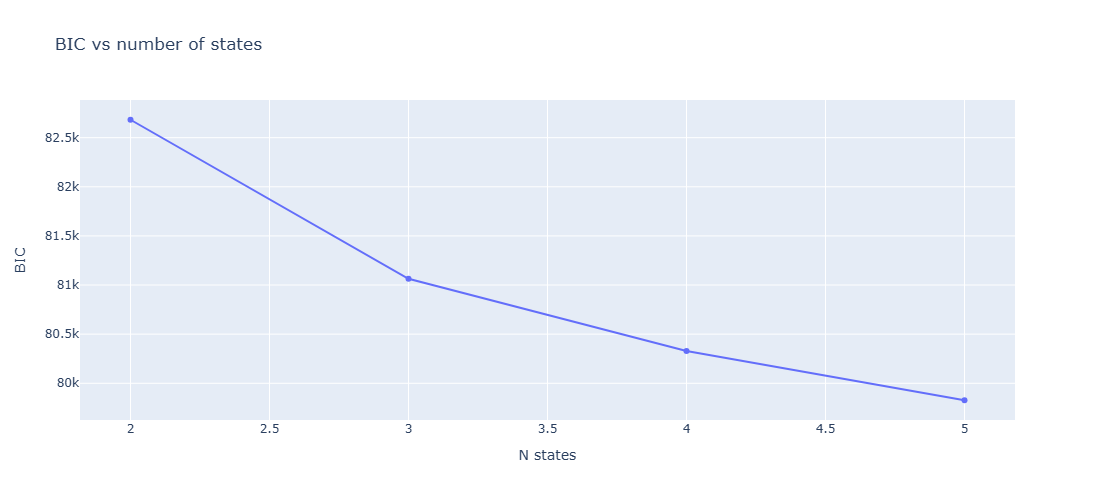

In [255]:
from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM
from sklearn.decomposition import PCA
import warnings

warnings.filterwarnings('ignore')

features = [
    'nh_nl_zscore',
    'ad_de_zscore',
    'vix_vix3m_ewmac',
    'vix',
    'cs_zscore',
    'tlt_trend',
    'dbc_trend',
    'dxy_trend',
    'spy_trend'
]

data_hmm = data.copy()

# --- Normalize all features ---
for feature in tqdm(features):
    data_hmm[feature] = cumulative_percentile(data_hmm[feature], 1e10, False)

# --- Remove first datapoints, as rank calculation is less reliable ---
data_hmm = data_hmm.iloc[100:]

# --- Input features ---
X = data_hmm[features].copy()
X = X.ffill().bfill().dropna()


# --- Fit model function ----
def fit_hmm(X, n_states, covariance_type="diag", random_state=42):
    hmm = GaussianHMM(
        n_components=n_states,
        covariance_type=covariance_type,
        n_iter=200,
        tol=1e-4,
        random_state=random_state
    )
    hmm.fit(X)
    return hmm

# --- Calculate BIC function ---
def bic(hmm, X):
    # BIC = -2*LL + p*ln(N)
    ll = hmm.score(X)
    K = hmm.n_components
    d = X.shape[1]
    # aprox parámetros para diag:
    # startprob: K-1 ; trans: K*(K-1)
    # means: K*d ; covars(diag): K*d
    p = (K - 1) + K*(K - 1) + K*d + K*d
    return -2*ll + p*np.log(X.shape[0])


# --- Optimum number of states: K ---
candidates = range(2, 6)  # 2 to 5 possible states
results = []
best = None
best_bic = np.inf

for K in candidates:
    m = fit_hmm(X, K, covariance_type="diag")
    b = bic(m, X)
    results.append((K, b))
    if b < best_bic:
        best_bic = b
        best = m

print("BIC by K:", results)

fig = go.Figure()
fig.add_trace(go.Scatter(x=[r[0] for r in results], y=[r[1] for r in results]))
fig.update_layout(width=1000, height=500, xaxis_title='N states', yaxis_title='BIC', title='BIC vs number of states')

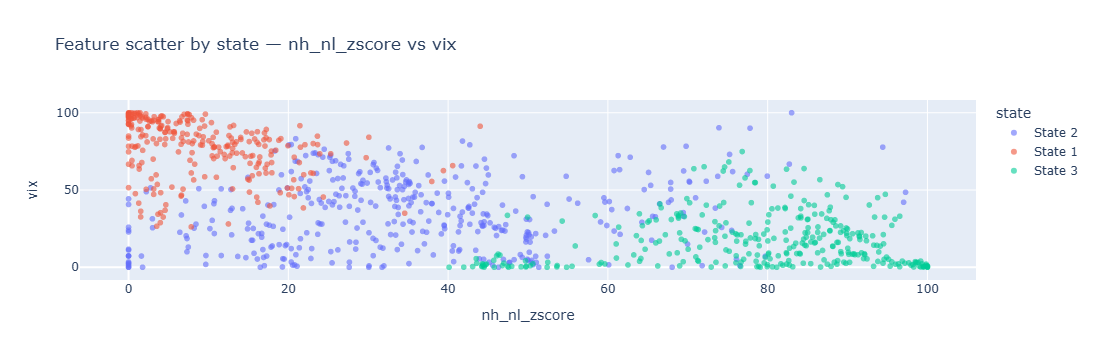

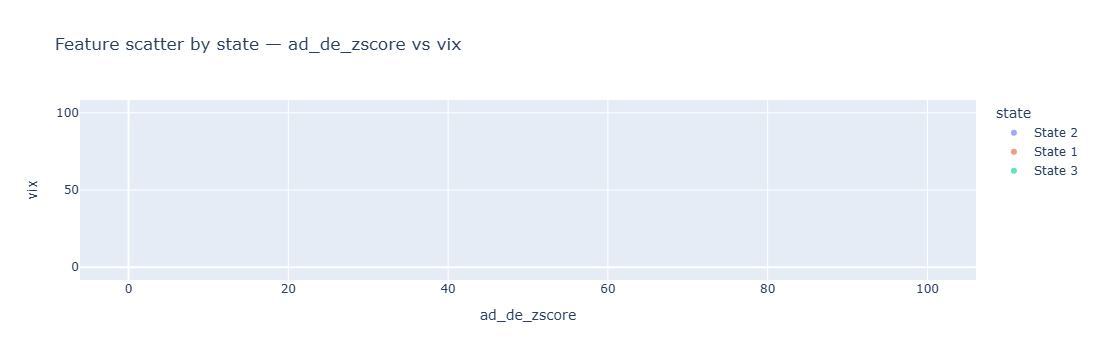

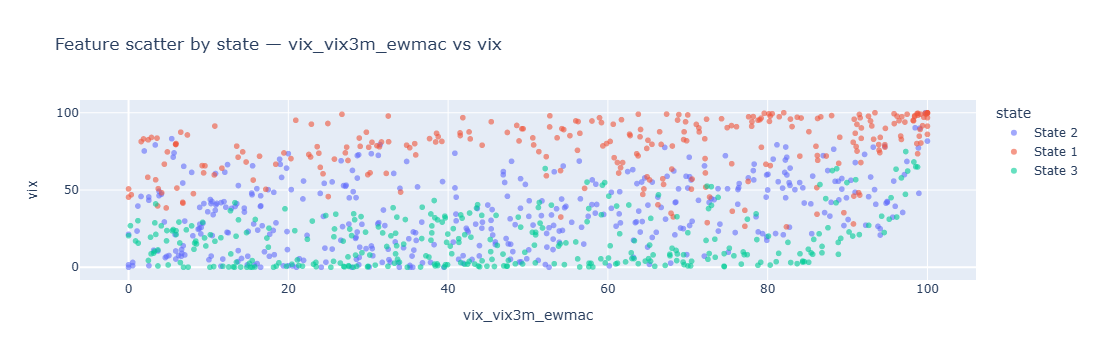

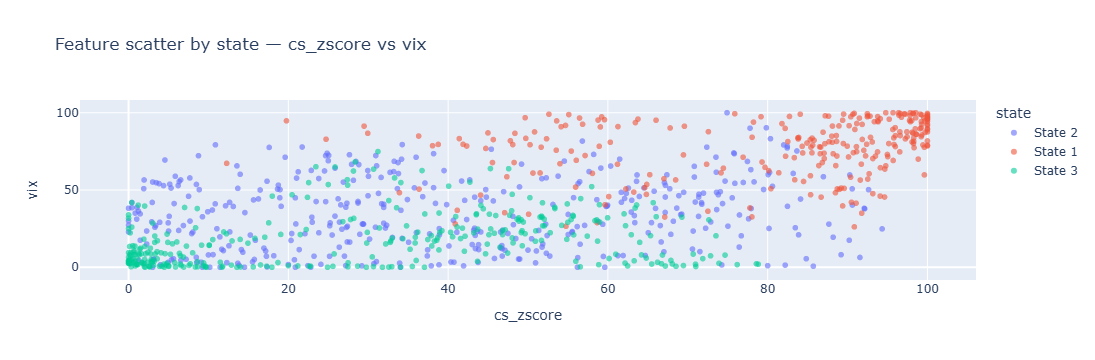

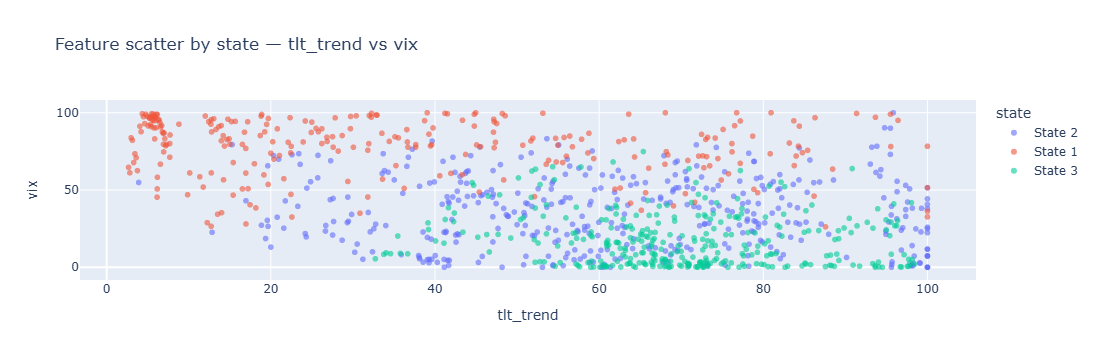

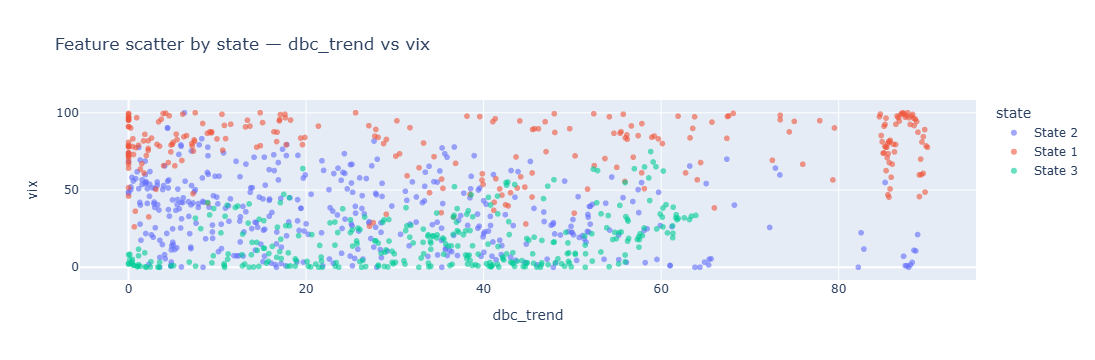

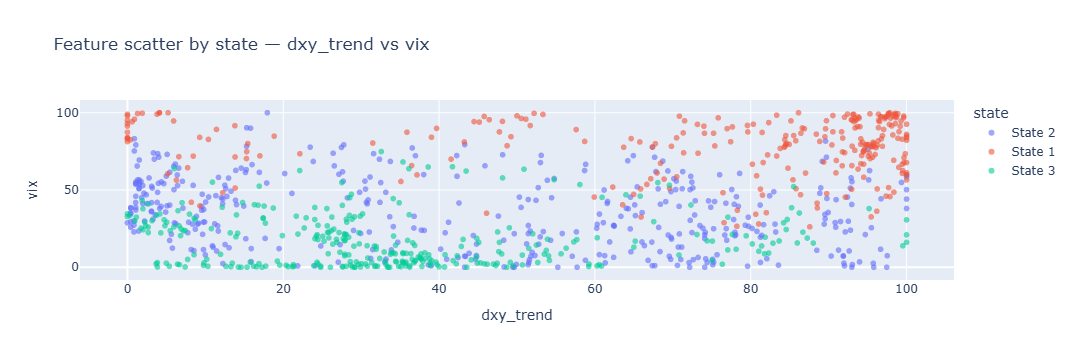

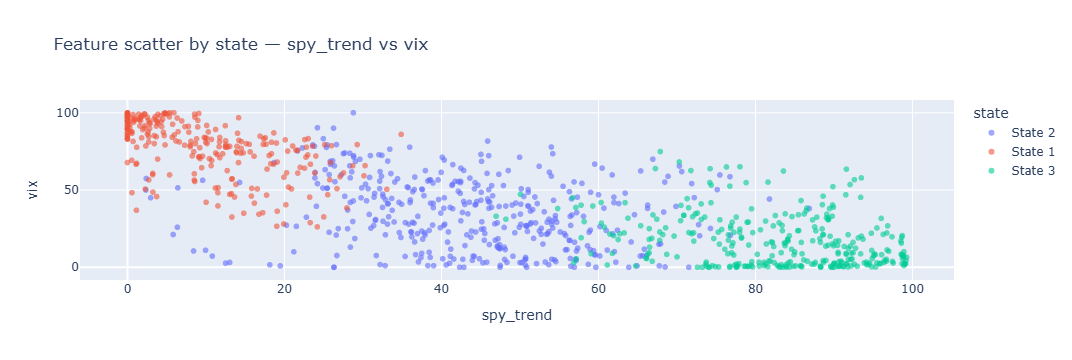

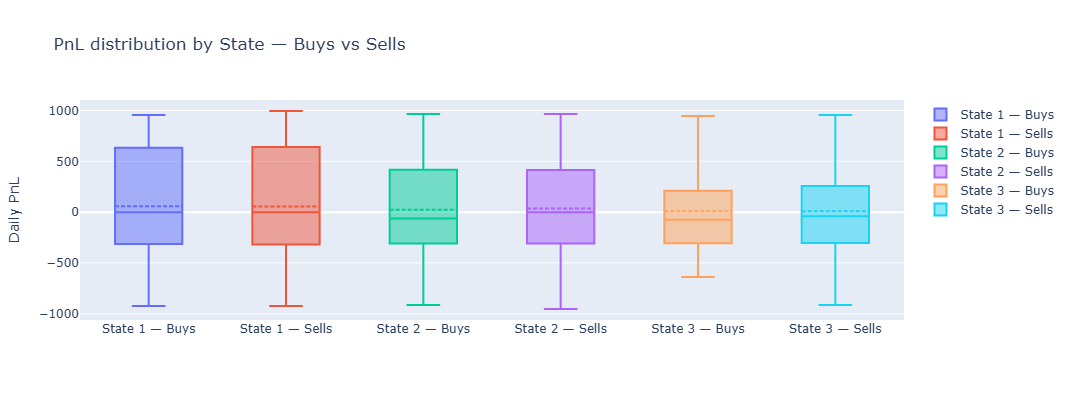

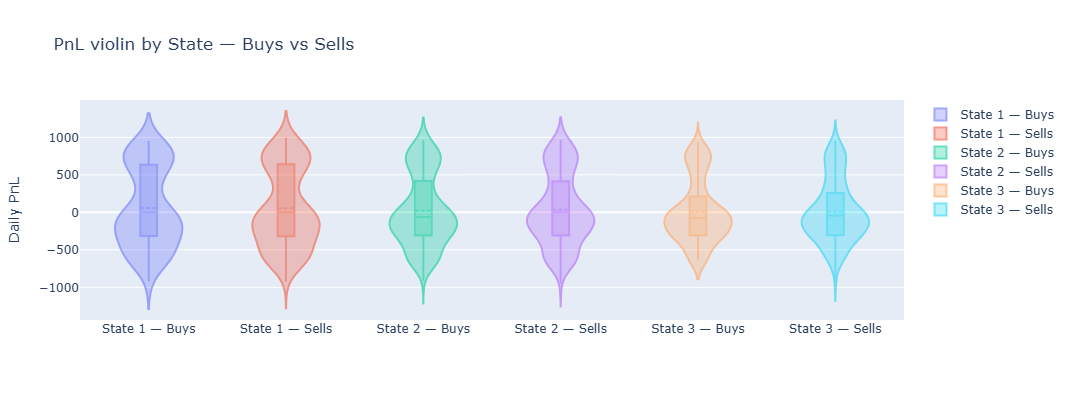

In [258]:
# --- Define inputs ---
X_df  = data_hmm[features].copy()
X_df = X_df.ffill().bfill().dropna()

X_df_dates = data.loc[X_df.index, 'date'].values

X = X_df.values
idx = X_df.index

# --- Train ---
m = fit_hmm(X, 3, covariance_type="diag")

# --- Predict ---
post   = m.predict_proba(X)      # (T, K)
states = m.predict(X)            # (T,)

# --- HMM Regime State dataframes ---
post_df  = pd.DataFrame(post, index=idx, columns=[f"state_{i}" for i in range(m.n_components)])
states_s = pd.Series(states, index=idx, name="state")
means    = pd.DataFrame(m.means_, columns=features, index=[f"state_{i}" for i in range(m.n_components)])


# ####################################################################################################
# # PLOT 1: STATE SEQUENCE
# ####################################################################################################
# states_s = pd.Series(states, index=X_df.index)
# state_labels = {i: f"State {i+1}" for i in range(m.n_components)}
# states_named = states_s.map(state_labels)

# fig_seq = go.Figure(data=[go.Heatmap(
#     z=[states_s.values],  # 1xT
#     x=X_df_dates,
#     y=["HMM state"],
#     colorscale="Viridis",
#     showscale=True,
#     colorbar=dict(title="State")
# )])
# fig_seq.update_layout(title="State sequence (Viterbi)", xaxis_title="", yaxis_title="", width=1000, height=400)
# fig_seq.show()

# ####################################################################################################
# # PLOT 2: FEATURES MEAN BY STATE
# ####################################################################################################
# means = pd.DataFrame(m.means_, columns=X_df.columns, index=[f"State {i+1}" for i in range(m.n_components)])

# fig_means = go.Figure(data=go.Heatmap(
#     z=means.values,
#     x=means.columns,
#     y=means.index,
#     colorscale="RdBu",
#     zmid=0,
#     colorbar=dict(title="Mean (std units)")
# ))
# fig_means.update_layout(title="Feature means by state", width=1000, height=400)
# fig_means.show()

# ####################################################################################################
# # PLOT 3: TRANSITION MATRIX
# ####################################################################################################
# tm = pd.DataFrame(m.transmat_, 
#                   index=[f"State {i+1}" for i in range(m.n_components)],
#                   columns=[f"State {i+1}" for i in range(m.n_components)])

# fig_tm = go.Figure(data=go.Heatmap(
#     z=tm.values, x=tm.columns, y=tm.index, colorscale="Blues", zmin=0, zmax=1,
#     colorbar=dict(title="P( to | from )")
# ))
# fig_tm.update_layout(title="Transition matrix", width=500, height=500)
# fig_tm.show()


# ####################################################################################################
# # PLOT 4: STATE DURATION
# ####################################################################################################
# max_dur = max(max(v) for v in dur_by_state.values())
# bin_edges = np.arange(0, max_dur + 20, 20)
# bin_labels = [f"{int(bin_edges[i])}-{int(bin_edges[i+1]-1)}" for i in range(len(bin_edges)-1)]

# # Construir histogramas agrupados manualmente
# fig_durs = go.Figure()

# for k, durs in dur_by_state.items():
#     counts, _ = np.histogram(durs, bins=bin_edges)
#     fig_durs.add_trace(go.Bar(
#         x=bin_labels,
#         y=counts,
#         name=f"State {k+1}",
#         opacity=0.7
#     ))

# fig_durs.update_layout(
#     barmode="group",
#     title="State duration (bars, grouped by 20)",
#     xaxis_title="Duration (bars)",
#     yaxis_title="Frequency",
#     width=1000,
#     height=400
# )
# fig_durs.show()

####################################################################################################
# PLOT 5: FEATURE vs FEATURE SCATTER BY STATE
####################################################################################################
for f1 in features:
    if f1 == 'vix':
        continue
    f2 = "vix"  # edita a gusto
    plot_df = X_df[[f1, f2]].copy()
    plot_df["state"] = states_named.values
    
    fig_sc = px.scatter(plot_df, x=f1, y=f2, color="state", opacity=0.6,
                        title=f"Feature scatter by state — {f1} vs {f2}")
    fig_sc.show()

####################################################################################################
# PLOT 6: STATS BY REGIME
####################################################################################################
# Boxplot
fig_box = go.Figure()
for name, grp in df_p.groupby("state"):
    fig_box.add_trace(go.Box(y=grp["buys_profit"], name=f"{name} — Buys", boxmean=True))
    fig_box.add_trace(go.Box(y=grp["sells_profit"], name=f"{name} — Sells", boxmean=True))
fig_box.update_layout(title="PnL distribution by State — Buys vs Sells", yaxis_title="Daily PnL", width=1000, height=400)
fig_box.show()

# Violin
fig_violin = go.Figure()
for name, grp in df_p.groupby("state"):
    fig_violin.add_trace(go.Violin(y=grp["buys_profit"], name=f"{name} — Buys",
                                   box_visible=True, meanline_visible=True, points=False, opacity=0.6))
    fig_violin.add_trace(go.Violin(y=grp["sells_profit"], name=f"{name} — Sells",
                                   box_visible=True, meanline_visible=True, points=False, opacity=0.6))
fig_violin.update_layout(title="PnL violin by State — Buys vs Sells", yaxis_title="Daily PnL", width=1000, height=400)
fig_violin.show()

In [250]:
states_s = pd.Series(states, index=X_df.index, name="state_id")
state_labels = {i: f"State {i+1}" for i in range(m.n_components)}
states_named = states_s.map(state_labels)

# Alinear PnLs
buys = data["buys_profit"].loc[X_df.index].astype(float)
sells = data["sells_profit"].loc[X_df.index].astype(float)

df_p = pd.DataFrame({
    "state_id": states_s,
    "state": states_named,
    "buys_profit": buys,
    "sells_profit": sells,
}).dropna()

ANN = 252  # si son diarios

def summarize(s):
    out = {}
    out["count"] = s.size
    out["mean"] = s.mean()
    out["std"]  = s.std()
    out["winrate"] = (s > 0).mean()
    out["sharpe_ann"] = (s.mean() / s.std()) * np.sqrt(ANN) if s.std() > 0 else np.nan
    return pd.Series(out)

summary_buys  = df_p.groupby("state")["buys_profit"].apply(summarize)
summary_sells = df_p.groupby("state")["sells_profit"].apply(summarize)

print("BUYS")
print(summary_buys.round(4))
print("\nSELLS")
print(summary_sells.round(4))

BUYS
state              
State 1  count         281.0000
         mean           56.9039
         std           533.6795
         winrate         0.3808
         sharpe_ann      1.6926
State 2  count         391.0000
         mean           22.7795
         std           469.5060
         winrate         0.3555
         sharpe_ann      0.7702
State 3  count         332.0000
         mean            7.6222
         std           416.2806
         winrate         0.3253
         sharpe_ann      0.2907
Name: buys_profit, dtype: float64

SELLS
state              
State 1  count         281.0000
         mean           55.2991
         std           519.7742
         winrate         0.3772
         sharpe_ann      1.6889
State 2  count         391.0000
         mean           35.3676
         std           473.2392
         winrate         0.3964
         sharpe_ann      1.1864
State 3  count         332.0000
         mean            9.2396
         std           405.3630
         winrate  

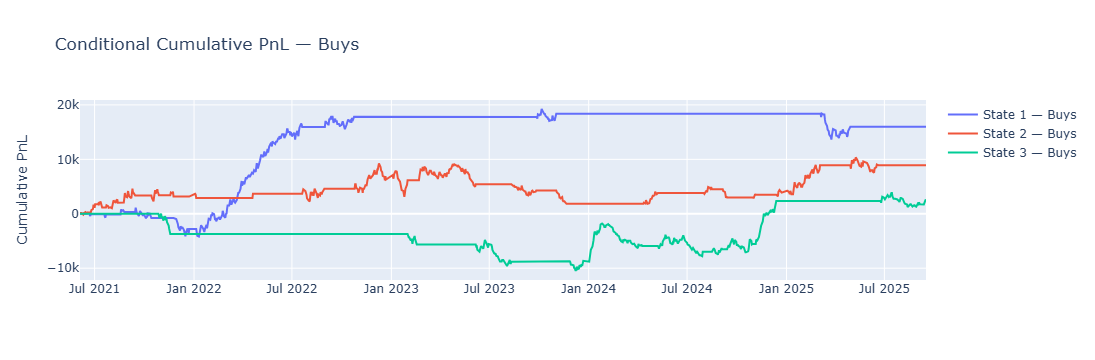

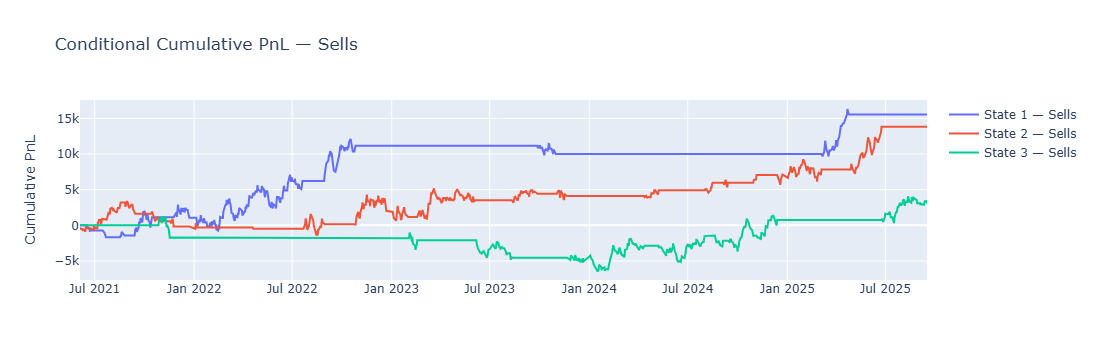

In [259]:
# Conditional curves on BUYs
cond_b = {}
for k in range(m.n_components):
    mask = (df_p["state_id"] == k)
    pnl_k = df_p["buys_profit"].where(mask, other=0.0)
    cond_b[f"State {k+1} — Buys"] = pnl_k.cumsum()

fig_cb = go.Figure()
for name, series in cond_b.items():
    fig_cb.add_trace(go.Scatter(x=X_df_dates, y=series, mode="lines", name=name))
fig_cb.update_layout(title="Conditional Cumulative PnL — Buys", yaxis_title="Cumulative PnL")
fig_cb.show()

# Conditional curves on SELLs
cond_s = {}
for k in range(m.n_components):
    mask = (df_p["state_id"] == k)
    pnl_k = df_p["sells_profit"].where(mask, other=0.0)
    cond_s[f"State {k+1} — Sells"] = pnl_k.cumsum()

fig_cs = go.Figure()
for name, series in cond_s.items():
    fig_cs.add_trace(go.Scatter(x=X_df_dates, y=series, mode="lines", name=name))
fig_cs.update_layout(title="Conditional Cumulative PnL — Sells", yaxis_title="Cumulative PnL")
fig_cs.show()


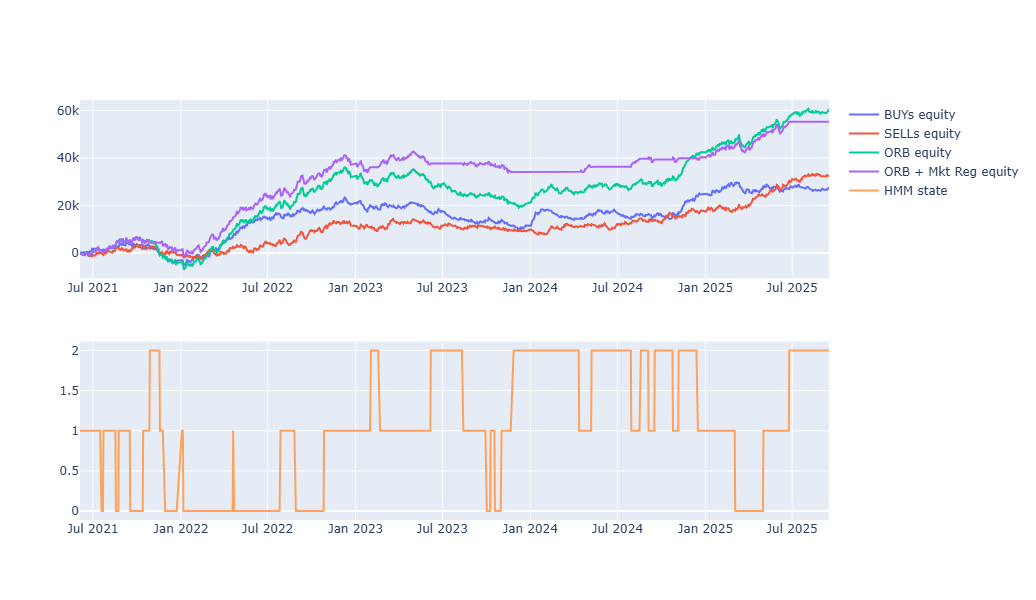

In [260]:
data_filt = data.iloc[X_df.index]
data_filt['state'] = states_s

data_filt['buys_equity'] = data_filt['buys_profit'].cumsum()
data_filt['sells_equity'] = data_filt['sells_profit'].cumsum()
data_filt['equity'] = data_filt['total_pnl'].cumsum()

mask_1 = data_filt['state'] == 0
mask_2 = data_filt['state'] == 1
mask_3 = data_filt['state'] == 2
data_filt['profit'] = data_filt['buys_profit'] + data_filt['sells_profit']
# data_filt.loc[mask_1, 'profit'] *= 1.5
data_filt.loc[mask_3, 'profit'] *= 0

data_filt['equity_mkt_reg'] = data_filt['profit'].cumsum()

fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Scatter(x=data_filt.date, y=data_filt.buys_equity, name='BUYs equity'))
fig.add_trace(go.Scatter(x=data_filt.date, y=data_filt.sells_equity, name='SELLs equity'))
fig.add_trace(go.Scatter(x=data_filt.date, y=data_filt.equity, name='ORB equity'))
fig.add_trace(go.Scatter(x=data_filt.date, y=data_filt.equity_mkt_reg, name='ORB + Mkt Reg equity'))

fig.add_trace(go.Scatter(x=data_filt.date, y=data_filt.state, name='HMM state'), row=2, col=1)

fig.update_layout(width=1000, height=600)
fig.update_xaxes(matches='x')

In [261]:
# --- Repeat for test data ---
n_years = (data_filt.date.max() - data_filt.date.min()).days / 365
annualized_return = (data_filt['equity'].values[-1] - data_filt['equity'].values[0]) / n_years
annualized_vol = data_filt['equity'].diff().std() * np.sqrt(252)
maxdd = (data_filt['equity'].cummax() - data_filt['equity']).max()
sharpe = annualized_return / annualized_vol
calmar = annualized_return / maxdd

annualized_return_filt = (data_filt['equity_mkt_reg'].values[-1] - data_filt['equity_mkt_reg'].values[0]) / n_years
annualized_vol_filt = data_filt['equity_mkt_reg'].diff().std() * np.sqrt(252)
maxdd_filt = (data_filt['equity_mkt_reg'].cummax() - data_filt['equity_mkt_reg']).max()
sharpe_filt = annualized_return_filt / annualized_vol_filt
calmar_filt = annualized_return_filt / maxdd_filt

print('ORB equity')
print('-----------------------------------')
print(f'Annualized return:     {int(annualized_return/1000)} k$')
print(f'Annualized vol:        {int(annualized_vol/1000)} k$')
print(f'Maximum drawdown:      {int(maxdd/1000)} k$')
print(f'Sharpe ratio:          {round(sharpe, 2)}')
print(f'Calmar ratio:          {round(calmar, 2)}')

print('\nORB + Mkt Reg equity')
print('-----------------------------------')
print(f'Annualized return:     {int(annualized_return_filt/1000)} k$')
print(f'Annualized vol:        {int(annualized_vol_filt/1000)} k$')
print(f'Maximum drawdown:      {int(maxdd_filt/1000)} k$')
print(f'Sharpe ratio:          {round(sharpe_filt, 2)}')
print(f'Calmar ratio:          {round(calmar_filt, 2)}')

ORB equity
-----------------------------------
Annualized return:     14 k$
Annualized vol:        10 k$
Maximum drawdown:      16 k$
Sharpe ratio:          1.35
Calmar ratio:          0.83

ORB + Mkt Reg equity
-----------------------------------
Annualized return:     12 k$
Annualized vol:        8 k$
Maximum drawdown:      8 k$
Sharpe ratio:          1.44
Calmar ratio:          1.48
